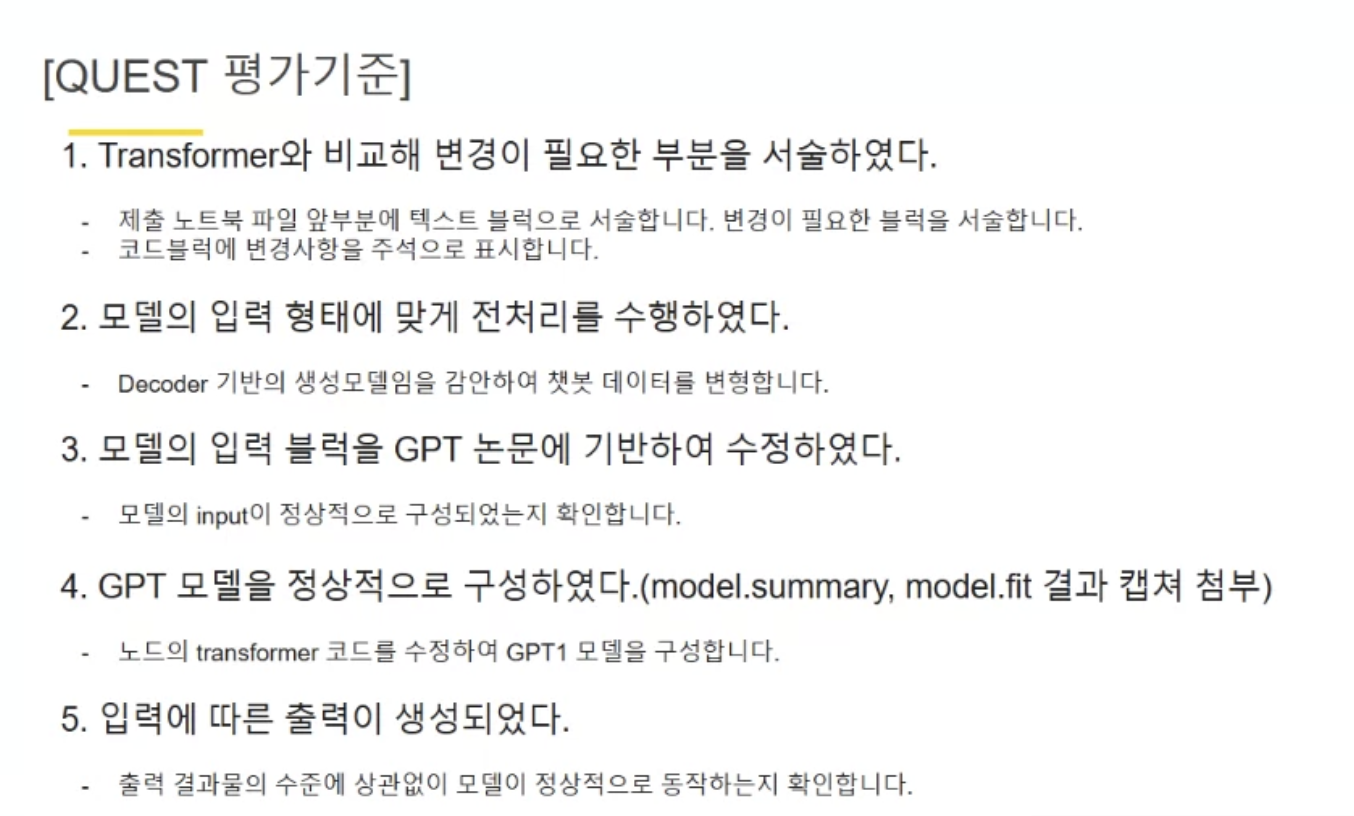

### 1. Transformer 와 비교해 변경이 필요한 부분

- Encoder 제거
- encoder-decoder Multi-head Attention 제거
- PositionalEncoding -> 학습 가능한 positional embedding 으로 변경


In [40]:
import pandas as pd
import seaborn as sns
import numpy as np

import tensorflow

print(tensorflow.__version__)

2.6.0


#### 데이터 수집하기

In [41]:
!mkdir -p ~/aiffel/transformer_chatbot/data/
!ln -sf ~/data/* ~/aiffel/transformer_chatbot/data/
!ls ~/aiffel/transformer_chatbot/data/

'ChatbotData .csv'


In [42]:
data = pd.read_csv('/aiffel/aiffel/transformer_chatbot/data/ChatbotData .csv')
data.head()


,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


챗봇 트레이닝용 문답 페어 11,876개
일상다반사 0, 이별(부정) 1, 사랑(긍정) 2로 레이블링

In [43]:
print('페어 샘플 갯수: {}'.format(len(data)) )

페어 샘플 갯수: 11823


In [44]:
data.label.value_counts()

0    5290
1    3570
2    2963
Name: label, dtype: int64

data 에 `label`이라는 열이 있었다. 
이를 이용하여 task specific finetuning 을 진행할 수 있을것 같다.

### 데이터 전처리하기


In [45]:
import re
# 전처리 함수
def preprocess_sentence(sentence):
    # 입력받은 sentence를 소문자로 변경하고 양쪽 공백을 제거
    sentence = sentence.lower().strip()

    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    # 숫자와 숫자가 아닌것들 사이에 거리를 만듭니다.
    sentence = re.sub(r"(\d+)", r" \1 ", sentence)
    # 영어와 한글사이에 거리를 만듭니다.
    sentence = re.sub(r"([a-zA-Z])([가-힣])", r"\1 \2", sentence)
    sentence = re.sub(r"([가-힣])([a-zA-Z])", r"\1 \2", sentence)
    # 연속한 빈칸은 1개의 빈칸으로 대체합니다.
    sentence = re.sub(r'[" "]]+', " ", sentence)

    # (a-z, A-Z, 한글:가-힣, 숫자:\d, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r'[^a-zA-Z\d가-힣\.?!,]', " ", sentence)
    sentence = sentence.strip()
    return sentence


- 숫자와 다른 문자 (영어, 한글)사이에 거리를 만들었다.
- 영어와 한글 사이에 거리를 만들었다.
- 공백과 특수문자 처리와 더불어서, 숫자와 한국어에 대해서 preprocessing 할 수 있도록, 각각에 대해 `\d`과 `가-힣` 부분을 추가했다.

In [46]:
# 전처리 하기
questions = data.Q.apply(preprocess_sentence).tolist()
answers = data.A.apply(preprocess_sentence).tolist()

In [47]:
# 전처리 결과 보기
for i in range(5):
    print(questions[i])
    print(answers[i])
    print()

12 시 땡 !
하루가 또 가네요 .

1 지망 학교 떨어졌어
위로해 드립니다 .

3 박 4 일 놀러가고 싶다
여행은 언제나 좋죠 .

3 박 4 일 정도 놀러가고 싶다
여행은 언제나 좋죠 .

ppl 심하네
눈살이 찌푸려지죠 .



### 2. 모델의 입력 형태에 맞게 전처리 수행
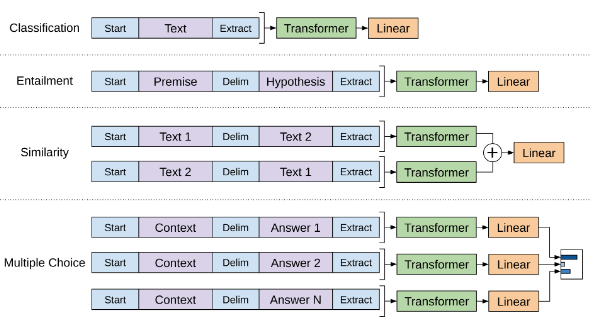

- 기존의 question, answer pair 를 '\$' 를 구분자로 하여 하나의 연속된 시퀀스로 만든다.
- tokenizer 를 만들 때는, 기존처럼 questions, answers를 합친 corpus 를 활용해서 vocab 을 만든다.
- QnA 데이터를 만들때, tokenizing 과정에서 QnA 는 '\$'에 해당하는 구분자를 Tokenizer 에 넣어준다.

### SubwordTextEncoder 사용해 tokinzation 수행
한국어 데이터는 형태소 분석기를 사용하여 토크나이징을 해야 한다고 많은 분이 알고 있습니다. 하지만 여기서는 형태소 분석기가 아닌 위 실습에서 사용했던 내부 단어 토크나이저인 SubwordTextEncoder를 그대로 사용해보세요.

In [48]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, 
    target_vocab_size=2**13)

preprocessing 된 corpus 로 부터 `tfds.deprecated.text.SubwordTextEncoder`를 사용하여 tokenize 했다. 

In [49]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
DELIM_TOKEN = [tokenizer.vocab_size + 2]
PAD_TOKEN = [tokenizer.vocab_size + 3]

print('START_TOKEN 의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN 의 번호 :' ,[tokenizer.vocab_size + 1])
print('DELIM_TOKEN 의 번호 :' ,[tokenizer.vocab_size + 2])
print('PAD_TOKEN 의 번호 :' ,[tokenizer.vocab_size + 3])
# 시작 토큰과 종료 토큰을 고려하여 +4를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 4
print(VOCAB_SIZE)

START_TOKEN 의 번호 : [8157]
END_TOKEN 의 번호 : [8158]
DELIM_TOKEN 의 번호 : [8159]
PAD_TOKEN 의 번호 : [8160]
8161


          questions       answers           qna
count  11823.000000  11823.000000  11823.000000
mean       4.025713      4.758691      9.784403
std        1.931323      2.015306      3.030765
min        1.000000      1.000000      3.000000
25%        3.000000      3.000000      8.000000
50%        4.000000      4.000000      9.000000
75%        5.000000      6.000000     11.000000
max       19.000000     26.000000     35.000000


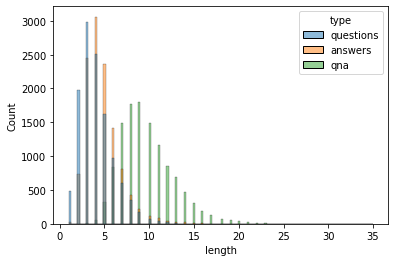

In [50]:
# 길이 분포 확인
qna = [q + ' $ ' + a for q, a in zip(questions, answers)]

tmp_df = pd.DataFrame(
    {'questions': [len(s.split(' ')) for s in questions], 
     'answers': [len(s.split(' ')) for s in answers], 
     'qna': [len(s.split(' ')) for s in qna]
    })
sns.histplot(tmp_df.melt(
            value_vars=['questions', 'answers', 'qna'], 
            var_name='type',
            value_name = 'length',),
             x='length', hue='type')
# sns.histplot(len_a, label='answers')

print(tmp_df.describe())

In [51]:
print(tmp_df['questions'].quantile(0.99))
print(tmp_df['answers'].quantile(0.99))
print(tmp_df['qna'].quantile(0.99))

# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40

10.0
12.0
19.0


최대 토큰 갯수를 정하기 위해서 question 과 answer 문장들의 예상 토큰 개수의 분포를 분석했다. 99% 의 문장이 토큰 갯수가 19개 보다 작아서 `MAX_LENGTH = 21` 로 설정했다.

In [52]:
import tensorflow as tf
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs, tokenized_pair = [], [], []
  
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence3 = START_TOKEN + tokenizer.encode(sentence1) + DELIM_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH and len(sentence3) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
            tokenized_pair.append(sentence3)
  
    # 최대 길이 40으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post', value=PAD_TOKEN[0])
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post', value=PAD_TOKEN[0])
    tokenized_pair = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_pair, maxlen=MAX_LENGTH, padding='post', value=PAD_TOKEN[0])
  
    return tokenized_inputs, tokenized_outputs, tokenized_pair

In [53]:
tokenized_Q, tokenized_A, tokenized_QnA = tokenize_and_filter(questions, answers)
_, _, tokenized_non_QnA = tokenize_and_filter(questions[1:], answers[:-1])

In [54]:
for i in range(3):
    print(tokenized_Q[i], tokenized_A[i], tokenized_QnA[i], sep='\n')
    print('-'*40)

[8157 7895 5174 3065   43 8158 8160 8160 8160 8160 8160 8160 8160 8160
 8160 8160 8160 8160 8160 8160 8160 8160 8160 8160 8160 8160 8160 8160
 8160 8160 8160 8160 8160 8160 8160 8160 8160 8160 8160 8160]
[8157 3849   74 7884    1 8158 8160 8160 8160 8160 8160 8160 8160 8160
 8160 8160 8160 8160 8160 8160 8160 8160 8160 8160 8160 8160 8160 8160
 8160 8160 8160 8160 8160 8160 8160 8160 8160 8160 8160 8160]
[8157 7895 5174 3065   43 8159 3849   74 7884    1 8158 8160 8160 8160
 8160 8160 8160 8160 8160 8160 8160 8160 8160 8160 8160 8160 8160 8160
 8160 8160 8160 8160 8160 8160 8160 8160 8160 8160 8160 8160]
----------------------------------------
[8157  172   47  925 7933 1001 1730 8158 8160 8160 8160 8160 8160 8160
 8160 8160 8160 8160 8160 8160 8160 8160 8160 8160 8160 8160 8160 8160
 8160 8160 8160 8160 8160 8160 8160 8160 8160 8160 8160 8160]
[8157 1844 5497    1 8158 8160 8160 8160 8160 8160 8160 8160 8160 8160
 8160 8160 8160 8160 8160 8160 8160 8160 8160 8160 8160 8160 8160 8160
 

       questions  answers      qna
count    11822.0  11822.0  11822.0
mean        40.0     40.0     40.0
std          0.0      0.0      0.0
min         40.0     40.0     40.0
25%         40.0     40.0     40.0
50%         40.0     40.0     40.0
75%         40.0     40.0     40.0
max         40.0     40.0     40.0


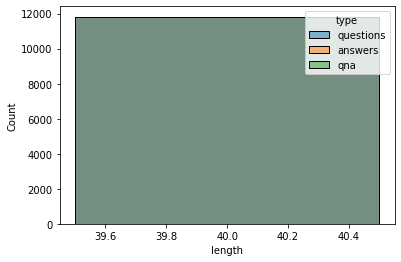

In [55]:
# 길이 분포 확인
tmp_df = pd.DataFrame(
    {'questions': [len(t) for t in tokenized_Q], 
     'answers': [len(t) for t in tokenized_A],
     'qna': [len(t) for t in tokenized_QnA],
     
    })
sns.histplot(tmp_df.melt(
            value_vars=['questions', 'answers', 'qna'], 
            var_name='type',
            value_name = 'length',),
             x='length', hue='type')
# sns.histplot(len_a, label='answers')

print(tmp_df.describe())

###### Temp end

교사 강요(Teacher Forcing) 사용하기

In [56]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
union_sentences = np.concatenate([tokenized_Q, tokenized_A], axis=0)
pretrain_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'dec_inputs': union_sentences[:, :-1] # batch size, max_len
    },
    {
        'text_output': union_sentences[:, 1:] # batch size, max_len
    },
))


qa_label = np.ones_like(tokenized_QnA[:, 1:]) * PAD_TOKEN[0]
qa_label[:,-1] = 1
nonqa_label = np.ones_like(tokenized_non_QnA[:, 1:]) * PAD_TOKEN[0]
nonqa_label[:,-1] = 0


qa_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'dec_inputs': np.concatenate([tokenized_QnA[:, :-1],
                                      tokenized_non_QnA[:, :-1]], axis=0) # batch size, max_len
    },
    {
        'text_output': np.concatenate([tokenized_QnA[:, 1:],
                                       tokenized_non_QnA[:, 1:]], axis=0), # batch size, max_len
        'task_output': np.concatenate([qa_label,nonqa_label], axis=0)
    },
))

In [57]:
np.concatenate([tokenized_QnA[:, :-1],
                                      tokenized_non_QnA[:, :-1]], axis=0).shape

(23644, 39)

In [58]:
np.concatenate([tokenized_QnA[:, 1:],
                                       tokenized_non_QnA[:, :-1]], axis=0).shape

(23644, 39)

In [59]:
np.concatenate([qa_label,nonqa_label], axis=0)[0]

array([8160, 8160, 8160, 8160, 8160, 8160, 8160, 8160, 8160, 8160, 8160,
       8160, 8160, 8160, 8160, 8160, 8160, 8160, 8160, 8160, 8160, 8160,
       8160, 8160, 8160, 8160, 8160, 8160, 8160, 8160, 8160, 8160, 8160,
       8160, 8160, 8160, 8160, 8160,    1], dtype=int32)

In [60]:
len(pretrain_dataset)

23644

In [61]:
def split_train_test(dataset):
    train_dataset = dataset.take(len(dataset)//5*4)
    test_dataset = dataset.skip(len(dataset)//5*4)
    return train_dataset, test_dataset

pretrain_train, pretrain_val = split_train_test(pretrain_dataset)

In [62]:
def prepare_dataset(*datasets):
    BATCH_SIZE = 64
    BUFFER_SIZE = 20000
    return tuple(dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE) 
              for dataset in datasets)

pretrain_train, pretrain_val = prepare_dataset(pretrain_train, pretrain_val)

In [63]:
qa_train, qa_val = split_train_test(qa_dataset)
qa_train, qa_val = prepare_dataset(qa_train, qa_val)

Step 4. 모델 구성하기
위 실습 내용을 참고하여 트랜스포머 모델을 구현합니다.

### 3. 모델의 입력 블럭을 GPT 논문에 기반하여 수정
- [변경사항] 포지셔널 인코딩 -> trainable positional embedding
- [변경사항] encoder out 을 Input 으로 넣던것 제거
- [변경사항] Encoder input 제거, 

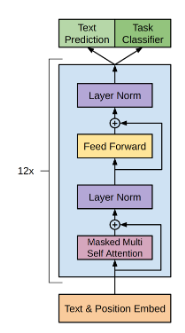

In [64]:
import tensorflow as tf
from modules import MultiHeadAttention

# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    # [변경사항] enc_outputs 제거
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (masked multi head 셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask,
        })
    # 멀티 헤드 어텐션의 결과는 Add & LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention + inputs)

    # [제거] 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)


    # 두번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 Add & LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention)

    return tf.keras.Model(
        inputs=[inputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)


In [65]:
# 포지셔널 인코딩 레이어
class PositionalEmbedding(tf.keras.layers.Embedding):

    def __init__(self, max_len, d_model):
        super(PositionalEmbedding, self).__init__(max_len, d_model)
        self.pos_encoding = tf.keras.layers.Embedding(max_len, d_model)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        
        positional_embedding = super(PositionalEmbedding, self).call( 
            tf.range( input_shape[1]) 
        )
        new_shape = [1 for _ in inputs.get_shape().as_list()]
        new_shape[1] = input_shape[1]
        new_shape[-1] = positional_embedding.get_shape().as_list()[-1]
        positional_embedding = tf.reshape(positional_embedding, new_shape)
        return inputs + positional_embedding

In [66]:
def decoder_block(
        vocab_size,
        max_len,
        num_layers,
        units,
        d_model,
        num_heads,
        dropout,
        name='decoder'):
    # input1
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    # [변경사항] encoder out 을 Input 으로 넣던것 제거
    #input2: look_ahead_mask
    look_ahead_mask = tf.keras.Input(
          shape=(1, None, None), name='look_ahead_mask')

    # input3: 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # [변경사항] 포지셔널 인코딩 -> trainable positional embedding
#     embeddings = PositionalEncoding(max_len, d_model)(embeddings)
    embeddings = PositionalEmbedding(max_len, d_model)(embeddings) 
    # 내부에서 기존 embedding 과 PositionalEmbedding을 합쳐서 반환함.
    
    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, look_ahead_mask, padding_mask])
        
    return tf.keras.Model(
          inputs=[inputs, look_ahead_mask, padding_mask],
          outputs=outputs,
          name=name)

In [67]:
from utils import create_padding_mask, create_look_ahead_mask

def MultiHeadDecoder(vocab_size,
                     max_len,
                  num_layers,
                  units,
                  d_model,
                  num_heads,
                  dropout,
                  pad_token=PAD_TOKEN[0],
                  name="transformer"):
    # [변경사항] Encoder input 제거, 
    
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),  # 1, position, position
        arguments={'pad_token':pad_token},
        name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, 
        output_shape=(1, 1, None), # 1, 1, position
        arguments={'pad_token':pad_token},
        name='dec_padding_mask')(dec_inputs, pad_token)
    
    # [변경사항] Encoder 제거
    
    # 디코더
    dec_outputs = decoder_block(
        vocab_size=vocab_size,
        max_len=max_len,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    # [변경사항] Encoder input 제거, 
    )(inputs=[dec_inputs, look_ahead_mask, dec_padding_mask]) 

    # 완전연결층
    # [변경사항] Activation function 사용
    outputs = tf.keras.layers.Dense(units=vocab_size, name="text_output", 
#                                     activation='softmax'
                                   )(dec_outputs)
    outputs2 = tf.keras.layers.Dense(units=2, name="task_output")(dec_outputs)

    return tf.keras.Model(inputs=[dec_inputs], outputs=[outputs, outputs2], name=name)

### 4. GPT 모델을 정상적으로 구성
- model.summary 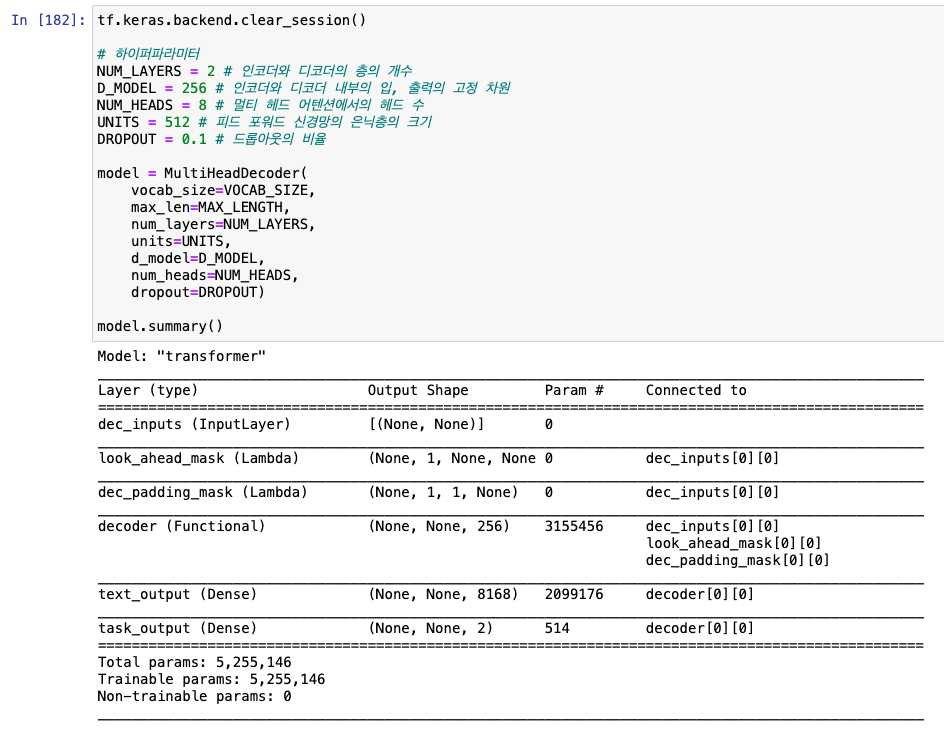
- model.fit 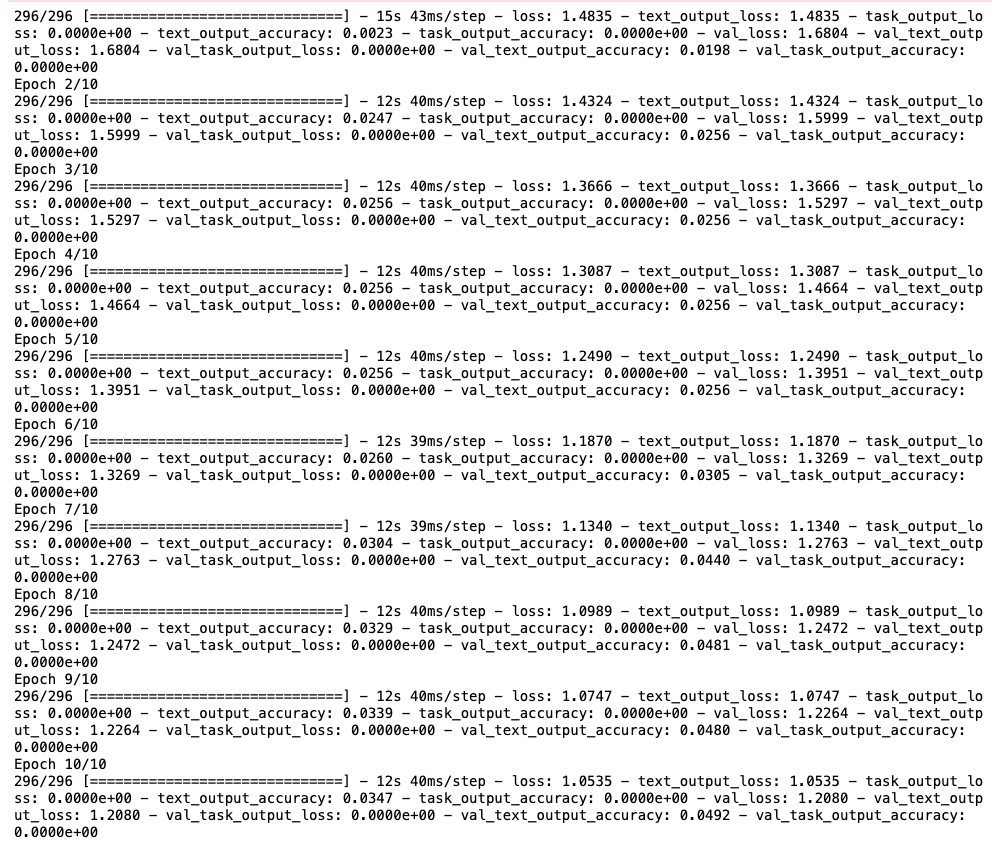

In [68]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = MultiHeadDecoder(
    vocab_size=VOCAB_SIZE,
    max_len=MAX_LENGTH, 
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
look_ahead_mask (Lambda)        (None, 1, None, None 0           dec_inputs[0][0]                 
__________________________________________________________________________________________________
dec_padding_mask (Lambda)       (None, 1, 1, None)   0           dec_inputs[0][0]                 
__________________________________________________________________________________________________
decoder (Functional)            (None, None, 256)    3153664     dec_inputs[0][0]                 
                                                                 look_ahead_mask[0][0]  

In [69]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step) # equal to step ** -0.5
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

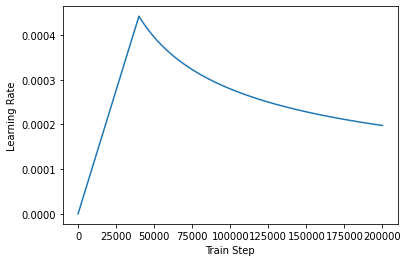

In [70]:
import matplotlib.pyplot as plt
sample_learning_rate = CustomSchedule(d_model=128, warmup_steps=4e+4)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### Pretraining

In [71]:
def loss_function(y_true, y_pred):
    # reshape y_true into (batch size, MAX_LENGTH-1)
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    y_pred = tf.reshape(y_pred, shape=(-1, MAX_LENGTH - 1, VOCAB_SIZE))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)
    
    mask = tf.cast(tf.not_equal(y_true, PAD_TOKEN[0]), # True if y_treu is 0, otherwise False
                   tf.float32)
    
    # cast boolian tensor into tf.float32
    # to multiplicate with loss tensor(tf.float32)
    loss = tf.multiply(loss, mask) # element-wise multiplication

    return tf.reduce_mean(loss)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

In [72]:
learning_rate = CustomSchedule(D_MODEL, warmup_steps=4e+4)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

model.compile(
    optimizer=optimizer, 
    loss=loss_function, 
    metrics=[accuracy])

In [73]:
EPOCHS = 50
history = model.fit(pretrain_train, 
                    epochs=EPOCHS, 
                    validation_data=pretrain_val,
                    verbose=1)

Epoch 1/50


296/296 [==============================] - 15s 41ms/step - loss: 1.4966 - text_output_loss: 1.4966 - task_output_loss: 0.0000e+00 - text_output_accuracy: 4.6097e-05 - task_output_accuracy: 0.0000e+00 - val_loss: 1.7005 - val_text_output_loss: 1.7005 - val_task_output_loss: 0.0000e+00 - val_text_output_accuracy: 4.2265e-04 - val_task_output_accuracy: 0.0000e+00
Epoch 2/50
296/296 [==============================] - 11s 39ms/step - loss: 1.4502 - text_output_loss: 1.4502 - task_output_loss: 0.0000e+00 - text_output_accuracy: 0.0192 - task_output_accuracy: 0.0000e+00 - val_loss: 1.6180 - val_text_output_loss: 1.6180 - val_task_output_loss: 0.0000e+00 - val_text_output_accuracy: 0.0257 - val_task_output_accuracy: 0.0000e+00
Epoch 3/50
296/296 [==============================] - 11s 39ms/step - loss: 1.3810 - text_output_loss: 1.3810 - task_output_loss: 0.0000e+00 - text_output_accuracy: 0.0256 - task_output_accuracy: 0.0000e+00 - val_loss: 1.5379 - val_text_output_loss: 1.5379 - val_task_out

296/296 [==============================] - 12s 40ms/step - loss: 0.8454 - text_output_loss: 0.8454 - task_output_loss: 0.0000e+00 - text_output_accuracy: 0.0475 - task_output_accuracy: 0.0000e+00 - val_loss: 1.1034 - val_text_output_loss: 1.1034 - val_task_output_loss: 0.0000e+00 - val_text_output_accuracy: 0.0570 - val_task_output_accuracy: 0.0000e+00
Epoch 24/50
296/296 [==============================] - 12s 41ms/step - loss: 0.8300 - text_output_loss: 0.8300 - task_output_loss: 0.0000e+00 - text_output_accuracy: 0.0487 - task_output_accuracy: 0.0000e+00 - val_loss: 1.0992 - val_text_output_loss: 1.0992 - val_task_output_loss: 0.0000e+00 - val_text_output_accuracy: 0.0576 - val_task_output_accuracy: 0.0000e+00
Epoch 25/50
296/296 [==============================] - 12s 41ms/step - loss: 0.8146 - text_output_loss: 0.8146 - task_output_loss: 0.0000e+00 - text_output_accuracy: 0.0500 - task_output_accuracy: 0.0000e+00 - val_loss: 1.0947 - val_text_output_loss: 1.0947 - val_task_output_lo

296/296 [==============================] - 12s 40ms/step - loss: 0.4885 - text_output_loss: 0.4885 - task_output_loss: 0.0000e+00 - text_output_accuracy: 0.0865 - task_output_accuracy: 0.0000e+00 - val_loss: 1.1345 - val_text_output_loss: 1.1345 - val_task_output_loss: 0.0000e+00 - val_text_output_accuracy: 0.0604 - val_task_output_accuracy: 0.0000e+00
Epoch 46/50
296/296 [==============================] - 12s 40ms/step - loss: 0.4746 - text_output_loss: 0.4746 - task_output_loss: 0.0000e+00 - text_output_accuracy: 0.0883 - task_output_accuracy: 0.0000e+00 - val_loss: 1.1457 - val_text_output_loss: 1.1457 - val_task_output_loss: 0.0000e+00 - val_text_output_accuracy: 0.0603 - val_task_output_accuracy: 0.0000e+00
Epoch 47/50
296/296 [==============================] - 12s 40ms/step - loss: 0.4605 - text_output_loss: 0.4605 - task_output_loss: 0.0000e+00 - text_output_accuracy: 0.0904 - task_output_accuracy: 0.0000e+00 - val_loss: 1.1565 - val_text_output_loss: 1.1565 - val_task_output_lo

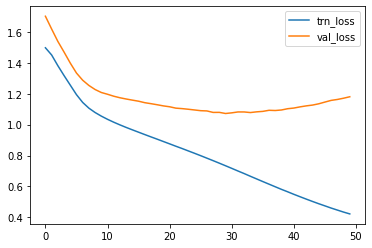

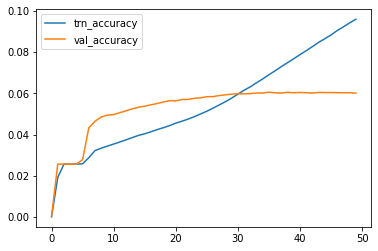

In [74]:
data = pd.DataFrame(history.history).reset_index()
plt.plot(data.index, data.text_output_loss, label='trn_loss')
plt.plot(data.index, data.val_text_output_loss, label='val_loss')
plt.legend();plt.show()
plt.plot(data.index, data.text_output_accuracy, label='trn_accuracy')
plt.plot(data.index, data.val_text_output_accuracy, label='val_accuracy')
plt.legend();plt.show()


In [75]:
model.save_weights(filepath='./logs/pretrained_e100_l7.4e-3_acc0.174.pt')

### Task specific finetuning

In [86]:
def loss_function(y_true, y_pred):
#     y_true_masked = tf.identity(y_true)
    mask = tf.cast(tf.not_equal(y_true, PAD_TOKEN[0]), # False if y_true equal (PAD_TOKEN), otherwise True
                   tf.int32) 

    y_true_masked = tf.multiply(y_true, mask)
    
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true_masked, y_pred)
    
    # cast boolian tensor into tf.float32
    mask = tf.cast(mask, # False if y_true equal (PAD_TOKEN), otherwise True
                   tf.float32) 

    # to multiplicate with loss tensor(tf.float32)
    loss = tf.multiply(loss, mask) # element-wise multiplication

    return tf.reduce_mean(loss)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

In [87]:
learning_rate = CustomSchedule(D_MODEL, warmup_steps=4e+3)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

model.compile(
    optimizer=optimizer, 
    loss=loss_function, 
    loss_weights = {'text_output': 0.5, 'task_output': 1.5},
    metrics=[accuracy])

In [88]:
EPOCHS = 25
history = model.fit(qa_train, 
                    epochs=EPOCHS, 
                    validation_data=qa_val,
                    verbose=1)

Epoch 1/25
296/296 [==============================] - 15s 42ms/step - loss: 0.7121 - text_output_loss: 1.3553 - task_output_loss: 0.0230 - text_output_accuracy: 0.1475 - task_output_accuracy: 0.0143 - val_loss: 0.8307 - val_text_output_loss: 1.5575 - val_task_output_loss: 0.0347 - val_text_output_accuracy: 0.1681 - val_task_output_accuracy: 0.0011
Epoch 2/25
296/296 [==============================] - 12s 39ms/step - loss: 0.5365 - text_output_loss: 1.0177 - task_output_loss: 0.0184 - text_output_accuracy: 0.1741 - task_output_accuracy: 0.0150 - val_loss: 0.7849 - val_text_output_loss: 1.4378 - val_task_output_loss: 0.0440 - val_text_output_accuracy: 0.1737 - val_task_output_accuracy: 5.4186e-06
Epoch 3/25
296/296 [==============================] - 12s 39ms/step - loss: 0.4957 - text_output_loss: 0.9385 - task_output_loss: 0.0176 - text_output_accuracy: 0.1838 - task_output_accuracy: 0.0152 - val_loss: 0.7342 - val_text_output_loss: 1.3313 - val_task_output_loss: 0.0457 - val_text_outpu

296/296 [==============================] - 12s 42ms/step - loss: 0.1953 - text_output_loss: 0.3577 - task_output_loss: 0.0110 - text_output_accuracy: 0.2653 - task_output_accuracy: 0.0196 - val_loss: 0.6943 - val_text_output_loss: 0.7917 - val_task_output_loss: 0.1990 - val_text_output_accuracy: 0.2649 - val_task_output_accuracy: 9.2117e-04
Epoch 25/25
296/296 [==============================] - 12s 41ms/step - loss: 0.1926 - text_output_loss: 0.3539 - task_output_loss: 0.0104 - text_output_accuracy: 0.2659 - task_output_accuracy: 0.0201 - val_loss: 0.6218 - val_text_output_loss: 0.7875 - val_task_output_loss: 0.1520 - val_text_output_accuracy: 0.2644 - val_task_output_accuracy: 0.0019


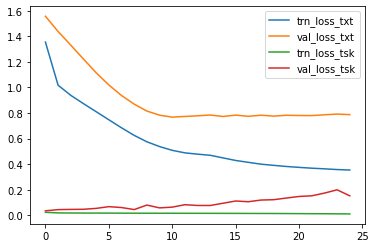

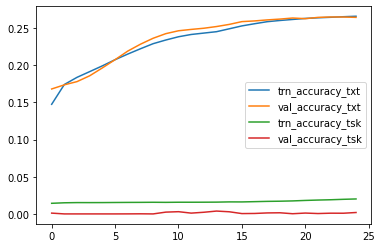

In [89]:
data = pd.DataFrame(history.history).reset_index()
plt.plot(data.index, data.text_output_loss, label='trn_loss_txt')
plt.plot(data.index, data.val_text_output_loss, label='val_loss_txt')
plt.plot(data.index, data.task_output_loss, label='trn_loss_tsk')
plt.plot(data.index, data.val_task_output_loss, label='val_loss_tsk')
plt.legend();plt.show()
plt.plot(data.index, data.text_output_accuracy, label='trn_accuracy_txt')
plt.plot(data.index, data.val_text_output_accuracy, label='val_accuracy_txt')
plt.plot(data.index, data.task_output_accuracy, label='trn_accuracy_tsk')
plt.plot(data.index, data.val_task_output_accuracy, label='val_accuracy_tsk')
plt.legend();plt.show()


In [91]:
model.save_weights(filepath='./logs/finetuned_e100_l7.4e-3_acc0.174.pt')

### 5. 입력에 따른 출력이 생성되었다.
- 모델이 정상적으로 동작하는지 확인

In [92]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    sequence = tf.expand_dims(
            START_TOKEN + tokenizer.encode(sentence),
        axis=0)
    
    
    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    output_sequence = tf.expand_dims(DELIM_TOKEN, axis=0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        input_seq = tf.concat([sequence, output_sequence], axis = 1)
        predictions, _ = model(inputs=[input_seq], training=False)
        predictions = predictions[:, -1:, :] # batch, position, embdding

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)


In [93]:
def sentence_generation(sentence, tokenizer):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
            [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence


In [94]:
for i in range(15):
    sentence_generation(questions[i], tokenizer)
    print('정답 : {}'.format(answers[i]))
    print()

입력 : 12 시 땡 !
출력 : 좋은 연애였길 바라요 .
정답 : 하루가 또 가네요 .

입력 : 1 지망 학교 떨어졌어
출력 : 매일 거울을 보며 스스로 칭찬해보세요 .
정답 : 위로해 드립니다 .

입력 : 3 박 4 일 놀러가고 싶다
출력 : 힘든 일이 있었나봐요 .
정답 : 여행은 언제나 좋죠 .

입력 : 3 박 4 일 정도 놀러가고 싶다
출력 : 끝은 항상 힘들지요 .
정답 : 여행은 언제나 좋죠 .

입력 : ppl 심하네
출력 : 눈살이 찌푸려지죠 .
정답 : 눈살이 찌푸려지죠 .

입력 : sd 카드 망가졌어
출력 : 다시 새로 사는 게 마음 편해요 .
정답 : 다시 새로 사는 게 마음 편해요 .

입력 : sd 카드 안돼
출력 : 다시 새로 사는 게 마음 편해요 .
정답 : 다시 새로 사는 게 마음 편해요 .

입력 : sns 맞팔 왜 안하지
출력 : 다시 새로 사는 게 마음 편해요 .
정답 : 잘 모르고 있을 수도 있어요 .

입력 : sns 시간낭비인 거 아는데 매일 하는 중
출력 : 잘 모르고 있을 수도 있어요 .
정답 : 시간을 정하고 해보세요 .

입력 : sns 시간낭비인데 자꾸 보게됨
출력 : 시간을 정하고 해보세요 .
정답 : 시간을 정하고 해보세요 .

입력 : sns 보면 나만 빼고 다 행복해보여
출력 : 자랑하는 자리니까요 .
정답 : 자랑하는 자리니까요 .

입력 : 가끔 궁금해
출력 : 그 사람도 그럴 거예요 .
정답 : 그 사람도 그럴 거예요 .

입력 : 가끔 뭐하는지 궁금해
출력 : 그 사람도 그럴 거예요 .
정답 : 그 사람도 그럴 거예요 .

입력 : 가끔은 혼자인게 좋다
출력 : 혼자를 즐기세요 .
정답 : 혼자를 즐기세요 .

입력 : 가난한 자의 설움
출력 : 혼자를 즐기세요 .
정답 : 돈은 다시 들어올 거예요 .



### 회고

#### 배운점
- Decoder 만으로 qna 생성이 잘 이루어질 수 있다는 것을 알게 됐다.
- positional embedding 과 Word embedding 을 합치는 과정에서, dimension 중, 하나만 맞지 않는 경우 broadcast된다는 점을 알았다.

#### 아쉬운점
- task specific label로 task loss 를 구현해보고 싶었으나, 어려움이 있었다.
- accuracy 외의 다른 지표도 시도해봤으면 좋을것 같다.

#### 느낀점
- 단순히 layer 만 늘려도 성능이 올라가는 경우가 있다.
    
#### 어려웠던점
- Positional embedding 을 수행할 때에, 가능해 보이는 다양한 구현 방법들 중에 무엇을 택해야 할지 감이 잘 안잡혔다.
- positional embedding 과 Word embedding 을 합칠 때, 텐서의 shape을 맞추는데 어려웠다. 